In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
from sklearn import preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import re
import string
import matplotlib.cm as cm
from matplotlib import rcParams
from prettytable import PrettyTable
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score,accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#Arabic_tweets_positive dataset

In [ ]:
df = pd.read_excel("/content/Dataset Arabic Corona Sentiment Analysis.xlsx")
df.head(10)

,Sentence,Class
0,السلام عليكم هل لقاح كورونا اجباري للحوامل?? ك...,0
1,سبحان الذي يخرج الخير من باطن الشر كان الناس م...,0
2,هل الوفاة كانت نتيجة مضاعفات لقاح كورونا الذي ...,0
3,التخصيص زي لقاح كورونا مو اجباري وصار اجباري و...,0
4,لقاح لا يمنع كورونا ولا يمنع دخول المستشفى ولا...,0
5,تقولون لقاح كورونا مو اجباري ومن الشهر الجاي ب...,0
6,يبون يعطونا القاح اجباري ... من يوم 22 ذي الحج...,0
7,#لا_للتطعيم_الاجباري32 والله صار الواحد يقول ا...,0
8,كل التطعيمات القديمة مبنية على دراسات وتجارب ا...,0
9,لقاح عادي لقاح عادي طيب ليش تبوننا ناخذه بالغص...,0


In [ ]:
#Count of positve tweets
print(len(df))

2400


In [ ]:
negative = df[df['Class '] == 0]

# Splitting into positive DataFrame (class == 2)
positive = df[df['Class '] == 2]

# Printing lengths of the new DataFrames
print("Negative DataFrame length:", len(negative))
print("Positive DataFrame length:", len(positive))

Negative DataFrame length: 1200
Positive DataFrame length: 1200


In [ ]:
positive.tail()

,Sentence,Class
2395,الحمدلله أخذنا #لقاح_كورونا الله يكتب لنا خيره...,2
2396,اخذت لقاح إكسفور وبما إنه سبق وجتني كورونا كان...,2
2397,أخذت الآن الجرعة الأولى من لقاح كورونا (فايزر)...,2
2398,الحمدلله تو اخذت أول جرعة لقاح كورونا،اللهم اج...,2
2399,الحمدلله اليوم أخذت الجرعة الأولى من لقاح كورو...,2


Dataset analysis

In [ ]:
#Checking null values count
np.sum(df.isnull().any(axis=1))

0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Class     2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB


# Preprocess data

In [ ]:
#cleaning tweet text
for letter in '#.][!XR':
    df['Sentence'] = df['Sentence'].astype(str).str.replace(letter,'')
#rwmove the punctuations
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [ ]:
#normalize_arabic
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

In [ ]:
#remove repeating char
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [ ]:
#processPost for applying all functions
def processPost(tweet):

    #Replace @username with empty string
    tweet = re.sub('@[^\s]+', ' ', tweet)

    #Convert www.* or https?://* to " "
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',tweet)

    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)

    # remove punctuations
    tweet= remove_punctuations(tweet)

    # normalize the tweet
    tweet= normalize_arabic(tweet)

    # remove repeated letters
    tweet=remove_repeating_char(tweet)

    return tweet

In [ ]:
# apply used to call the method processpost
df["Sentence"] = df['Sentence'].apply(lambda x: processPost(x))


Tokenize the tweet text

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
df["Sentence"] = df["Sentence"].apply(tokenizer.tokenize)

In [ ]:
df["Sentence"].head(10)

0    [السلام, عليكم, هل, لقاح, كورونا, اجباري, لحوا...
1    [سبحان, الذي, يخرج, الخير, من, باطن, الشر, كان...
2    [هل, الوفاه, كانت, نتيجه, مضاعفات, لقاح, كورون...
3    [التخصيص, زي, لقاح, كورونا, مو, اجباري, وصار, ...
4    [لقاح, لا, يمنع, كورونا, ولا, يمنع, دخول, المس...
5    [تقولون, لقاح, كورونا, مو, اجباري, ومن, الشهر,...
6    [يبون, يعطونا, القاح, اجباري, من, يوم, 2, ذي, ...
7    [لالتطعيمالاجباري32, واله, صار, الواحد, يقول, ...
8    [كل, التطعيمات, القديمه, مبنيه, علي, دراسات, و...
9    [لقاح, عادي, لقاح, عادي, طيب, ليش, تبونا, ناخذ...
Name: Sentence, dtype: object

Removing Stop words

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopwords_list = stopwords.words('arabic')

In [ ]:
stopwords_list

In [ ]:
print(len(stopwords_list))

754


In [ ]:
df["Sentence"]=df["Sentence"].apply(lambda x: [item for item in x if item not in stopwords_list])

In [ ]:
all_words = [word for tokens in df["Sentence"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df["Sentence"]]

VOCAB = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

55965 words total, with a vocabulary size of 13975
Max sentence length is 49


top 10 words in positive

In [ ]:
counter = Counter(all_words)

In [ ]:
counter.most_common(35)

[('لقاح', 2086),
 ('كورونا', 1991),
 ('القاح', 875),
 ('الحمدله', 860),
 ('علي', 847),
 ('اله', 590),
 ('الي', 530),
 ('ان', 519),
 ('لقاحكورونا', 403),
 ('اخذت', 402),
 ('اخذ', 399),
 ('الجرعه', 395),
 ('الاولي', 328),
 ('انا', 263),
 ('او', 261),
 ('اي', 253),
 ('الصحه', 228),
 ('تجريبي', 222),
 ('اخذتملقاحكوروناوالاباقي', 220),
 ('اجباري', 210),
 ('الناس', 196),
 ('لالتطعيمالاجباري', 190),
 ('تم', 184),
 ('اليوم', 180),
 ('حتي', 166),
 ('انه', 157),
 ('فايزر', 155),
 ('الحمد', 147),
 ('مضاعفات', 137),
 ('الا', 137),
 ('مو', 132),
 ('شي', 132),
 ('اول', 132),
 ('والحمدله', 131),
 ('اذا', 127)]

In [ ]:
counted_words = Counter(all_words)

words = []
counts = []
for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)

Arabic_tweets_negative dataset

<BarContainer object of 10 artists>

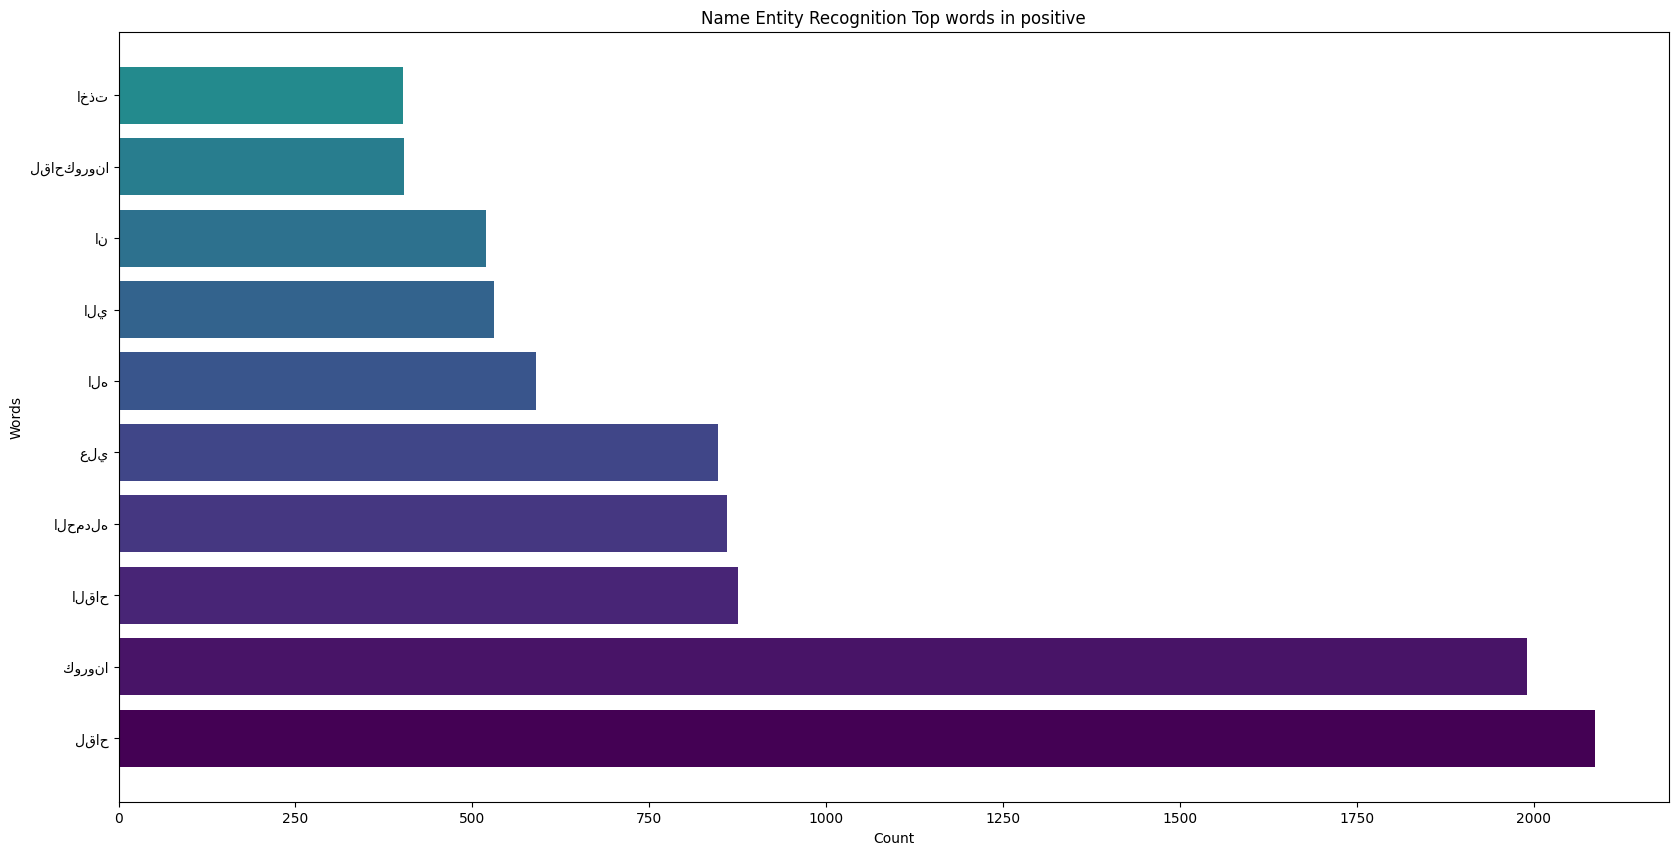

In [ ]:
colors = cm.viridis(np.linspace(0, 1, 20))
rcParams['figure.figsize'] = 20, 10

plt.title('Name Entity Recognition Top words in positive')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)


In [ ]:

negative.head(10)

,Sentence,Class
0,السلام عليكم هل لقاح كورونا اجباري للحوامل?? ك...,0
1,سبحان الذي يخرج الخير من باطن الشر كان الناس م...,0
2,هل الوفاة كانت نتيجة مضاعفات لقاح كورونا الذي ...,0
3,التخصيص زي لقاح كورونا مو اجباري وصار اجباري و...,0
4,لقاح لا يمنع كورونا ولا يمنع دخول المستشفى ولا...,0
5,تقولون لقاح كورونا مو اجباري ومن الشهر الجاي ب...,0
6,يبون يعطونا القاح اجباري ... من يوم 22 ذي الحج...,0
7,#لا_للتطعيم_الاجباري32 والله صار الواحد يقول ا...,0
8,كل التطعيمات القديمة مبنية على دراسات وتجارب ا...,0
9,لقاح عادي لقاح عادي طيب ليش تبوننا ناخذه بالغص...,0


In [ ]:
negative.head(10)
print(len(negative))

1200


In [ ]:
np.sum(negative.isnull().any(axis=1))

0

In [ ]:
for letter in '#.][!XR':
    negative['Sentence'] = negative['Sentence'].astype(str).str.replace(letter,'')
negative.head(11)

,Sentence,Class
0,السلام عليكم هل لقاح كورونا اجباري للحوامل?? ك...,0
1,سبحان الذي يخرج الخير من باطن الشر كان الناس م...,0
2,هل الوفاة كانت نتيجة مضاعفات لقاح كورونا الذي ...,0
3,التخصيص زي لقاح كورونا مو اجباري وصار اجباري و...,0
4,لقاح لا يمنع كورونا ولا يمنع دخول المستشفى ولا...,0
5,تقولون لقاح كورونا مو اجباري ومن الشهر الجاي ب...,0
6,يبون يعطونا القاح اجباري من يوم 22 ذي الحجه م...,0
7,لا_للتطعيم_الاجباري32 والله صار الواحد يقول ال...,0
8,كل التطعيمات القديمة مبنية على دراسات وتجارب ا...,0
9,لقاح عادي لقاح عادي طيب ليش تبوننا ناخذه بالغص...,0


In [ ]:
negative["Sentence"] = negative['Sentence'].apply(lambda x: processPost(x)) # apply used to call the method processpost



In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
negative["Sentence"] = negative["Sentence"].apply(tokenizer.tokenize)

negative["Sentence"].head(11)

0     [السلام, عليكم, هل, لقاح, كورونا, اجباري, لحوا...
1     [سبحان, الذي, يخرج, الخير, من, باطن, الشر, كان...
2     [هل, الوفاه, كانت, نتيجه, مضاعفات, لقاح, كورون...
3     [التخصيص, زي, لقاح, كورونا, مو, اجباري, وصار, ...
4     [لقاح, لا, يمنع, كورونا, ولا, يمنع, دخول, المس...
5     [تقولون, لقاح, كورونا, مو, اجباري, ومن, الشهر,...
6     [يبون, يعطونا, القاح, اجباري, من, يوم, 2, ذي, ...
7     [لالتطعيمالاجباري32, واله, صار, الواحد, يقول, ...
8     [كل, التطعيمات, القديمه, مبنيه, علي, دراسات, و...
9     [لقاح, عادي, لقاح, عادي, طيب, ليش, تبونا, ناخذ...
10    [لاتصدق, اكاذيب, مروجي, لقاح, كورونا, كذبه, ال...
Name: Sentence, dtype: object

In [ ]:
negative["Sentence"]=negative["Sentence"].apply(lambda x: [item for item in x if item not in stopwords_list])

In [ ]:
all_words = [word for tokens in negative["Sentence"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in negative["Sentence"]]

VOCAB = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

32995 words total, with a vocabulary size of 9878
Max sentence length is 49


In [ ]:
counter = Counter(all_words)
counter.most_common(35)

[('لقاح', 1196),
 ('كورونا', 1125),
 ('القاح', 559),
 ('علي', 549),
 ('ان', 337),
 ('الي', 337),
 ('اخذ', 219),
 ('تجريبي', 219),
 ('لقاحكورونا', 210),
 ('او', 203),
 ('اجباري', 185),
 ('انا', 180),
 ('اله', 177),
 ('اي', 169),
 ('لالتطعيمالاجباري', 168),
 ('الناس', 144),
 ('انه', 118),
 ('حتي', 116),
 ('مضاعفات', 111),
 ('مو', 109),
 ('اذا', 97),
 ('الصحه', 94),
 ('نرفضالقاحالاجباري', 88),
 ('ليش', 86),
 ('نسبه', 85),
 ('القاحات', 84),
 ('بدون', 84),
 ('الا', 83),
 ('شي', 79),
 ('يعني', 75),
 ('بسب', 73),
 ('يكون', 72),
 ('الجانبيه', 69),
 ('الحمدله', 68),
 ('ضد', 66)]

<BarContainer object of 10 artists>

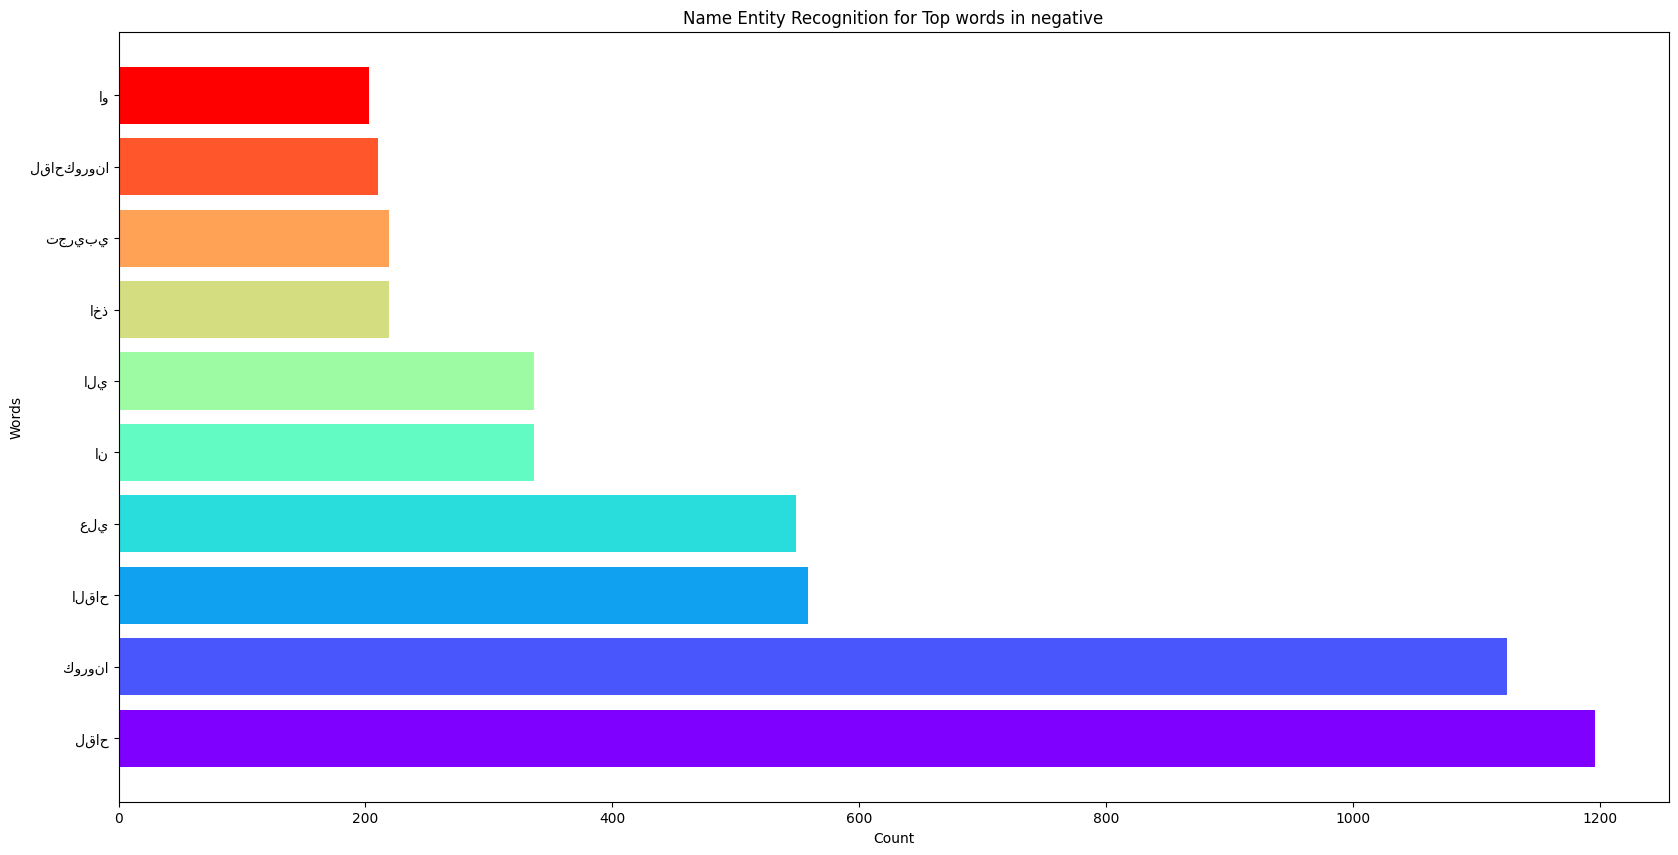

In [ ]:
counted_words = Counter(all_words)

words = []
counts = []
for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)
colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 20, 10

plt.title('Name Entity Recognition for Top words in negative')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

Combining the positive and negative

In [ ]:
#final_data = pd.concat([negative, positive], axis=0)
#final_data.head(15)
#total count of final data
#print(len(final_data))

## Features Extraction from tweets text with TFIDF unigram



In [ ]:
#Count of each target class
y=positive['Class ']
y.value_counts()


Class 
2    1200
Name: count, dtype: int64

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 1),
    max_features=10000
)

# Fit the TfidfVectorizer on the data
unigramdataGet = word_vectorizer.fit_transform(main['Sentence'].astype('str'))
unigramdataGet = unigramdataGet.toarray()

vocab = word_vectorizer.get_feature_names_out()
unigramdata_features = pd.DataFrame(np.round(unigramdataGet, 1), columns=vocab)
unigramdata_features[unigramdata_features > 0] = 1

unigramdata_features.head()

,00,01,02,03,0300,04,05,06,07,08,...,٩١,٩٥,٩٥٠,٩٦,٩٧,٩٨,٩٩,ٱجل,چنة,ڤايزر
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#encoding class as 1 for Postive class and 0 for negative class
pro= preprocessing.LabelEncoder()
encpro=pro.fit_transform(main['Class '])
main['Class '] = encpro




In [ ]:
#getting features and Class
y=main['Class ']
X=unigramdata_features
#Spliting Dataset into 70% Training and 30% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=333)

Trainig and Testing with Machine Learning Algorithms
-Naive Bayes Algorithm
-Logistic Regression Algorithm
-Support Vector Machines Algorithm
-MLP Classifier Algorithm
-RandomFores Classifier Algorithm

### Logistic Regression Algorithm

In [ ]:

LR= LogisticRegression(penalty = 'l2', C = 1)
LR= LR.fit(X_train , y_train)
LR

LogisticRegression(C=1)

In [ ]:
#Model Evaluation
y_pred = LR.predict(X_test)
precision1 = precision_score(y_test, y_pred)
recall1 = recall_score(y_test, y_pred)
f11 = f1_score(y_test, y_pred)
accuracy1 = accuracy_score(y_test, y_pred)

print(":::::::::Metrics for Logistic Regression:::::::::")
print("Precision:", precision1)
print("Recall:", recall1)
print("F1-score:", f11)
print("Accuracy:", accuracy1)

:::::::::Metrics for Logistic Regression:::::::::
Precision: 0.9221556886227545
Recall: 0.8484848484848485
F1-score: 0.8837876614060258
Accuracy: 0.8875


### MLP Classifier Algorithm

In [ ]:
#
from sklearn.neural_network import MLPClassifier
MLPClassifierModel = MLPClassifier(activation='relu', # can be also identity , logistic , relu
                                   solver='lbfgs',  # can be also sgd , adam
                                   learning_rate='constant', # can be also invscaling , adaptive
                                   early_stopping= False,max_iter=200,
                                   alpha=0.0001 ,hidden_layer_sizes=(100, 3),random_state=99)
MLPClassifierModel.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 3), random_state=99, solver='lbfgs')

In [ ]:
#Model Evaluation
y_pred = MLPClassifierModel.predict(X_test)
precision2 = precision_score(y_test, y_pred)
recall2 = recall_score(y_test, y_pred)
f12 = f1_score(y_test, y_pred)
accuracy2 = accuracy_score(y_test, y_pred)

print(":::::::::Metrics for Neural Network:::::::::")
print("Precision:", precision2)
print("Recall:", recall2)
print("F1-score:", f12)
print("Accuracy:", accuracy2)

:::::::::Metrics for Neural Network:::::::::
Precision: 0.9382716049382716
Recall: 0.837465564738292
F1-score: 0.8850072780203785
Accuracy: 0.8902777777777777


### Random Forest Classifier Algorithm

In [ ]:

from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

RandomForestClassifier()

In [ ]:
y_pred = clf.predict(X_test)

# Calculate precision, recall, F1-score, and accuracy
precision3 = precision_score(y_test, y_pred)
recall3 = recall_score(y_test, y_pred)
f13 = f1_score(y_test, y_pred)
accuracy3 = accuracy_score(y_test, y_pred)
print(":::::::::Metrics for Random Forest:::::::::")
print("Precision:", precision3)
print("Recall:", recall3)
print("F1-score:", f13)
print("Accuracy:", accuracy3)

:::::::::Metrics for Random Forest:::::::::
Precision: 0.9318181818181818
Recall: 0.790633608815427
F1-score: 0.8554396423248882
Accuracy: 0.8652777777777778


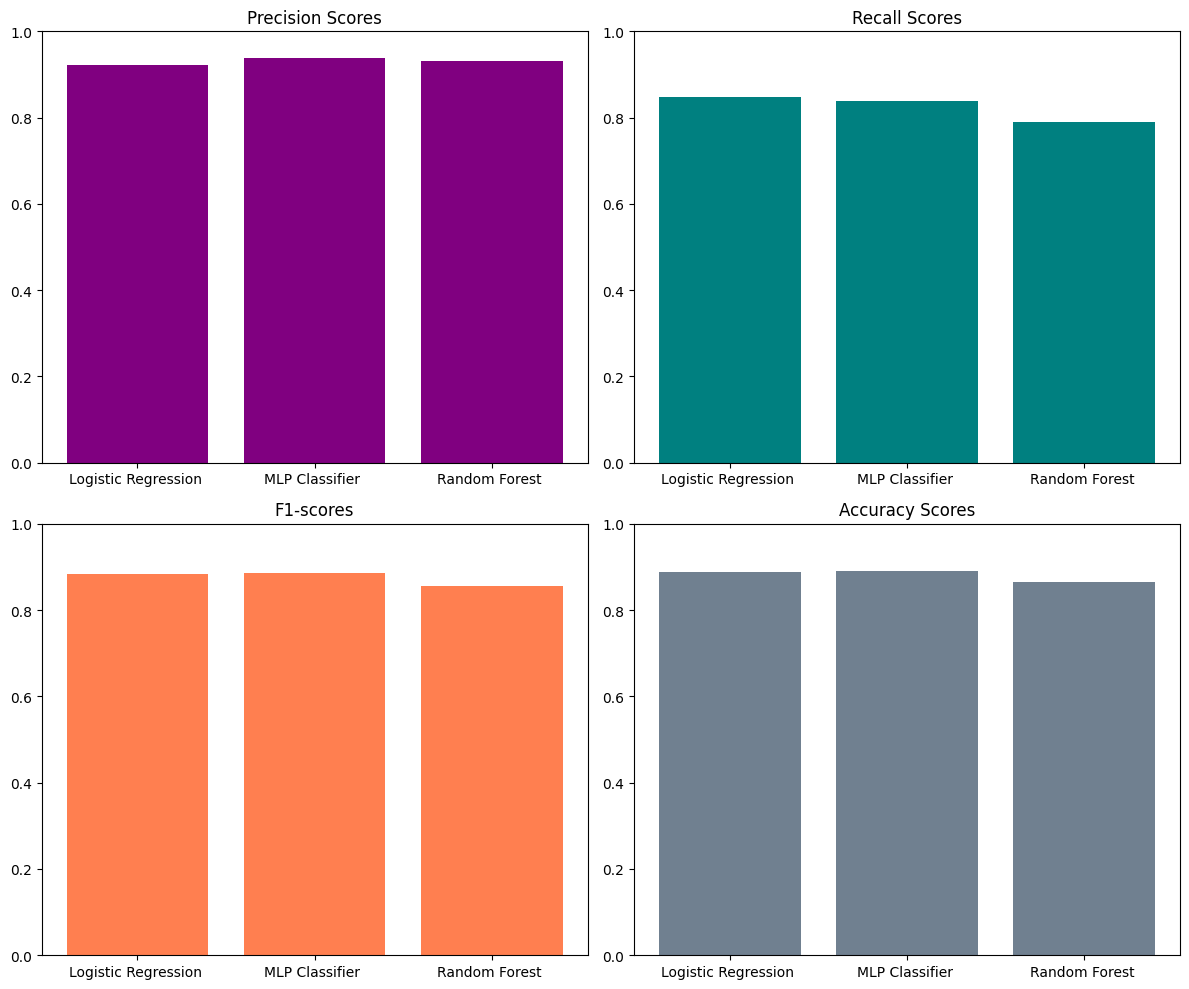

In [ ]:
import matplotlib.pyplot as plt

# Metrics for each model
models = ['Logistic Regression ', 'MLP Classifier ', 'Random Forest ']
precision_scores = [precision1, precision2, precision3]
recall_scores = [recall1, recall2, recall3]
f1_scores = [f11, f12, f13]
accuracy_scores = [accuracy1, accuracy2, accuracy3]

# Plotting
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Precision
ax[0, 0].bar(models, precision_scores, color='Purple')
ax[0, 0].set_title('Precision Scores')
ax[0, 0].set_ylim(0, 1)

# Recall
ax[0, 1].bar(models, recall_scores, color='Teal')
ax[0, 1].set_title('Recall Scores')
ax[0, 1].set_ylim(0, 1)

# F1-score
ax[1, 0].bar(models, f1_scores, color='Coral')
ax[1, 0].set_title('F1-scores')
ax[1, 0].set_ylim(0, 1)

# Accuracy
ax[1, 1].bar(models, accuracy_scores, color='SlateGray')
ax[1, 1].set_title('Accuracy Scores')
ax[1, 1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk.regexp import RegexpParser

# Download necessary resources (ensure internet connection)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Define stopwords list for Arabic (feel free to customize)
stopwords_ar = stopwords.words('arabic')
stopwords_ar.extend(['في', 'وال', 'ب', 'على', 'إلى', 'من'])  # Add common function words

def arabic_ner(text):
    """
    Performs named entity recognition (NER) on an Arabic sentence.

    Args:
        text (str): The Arabic sentence to process.

    Returns:
        list: A list of named entities found in the sentence.
    """

    # Preprocess text (lowercase, remove punctuation, stopwords)
    text = text.lower()
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stopwords_ar]

    # Apply POS tagging (ensure accuracy for NER)
    pos_tagged = pos_tag(tokens)

    # Define a regular expression grammar for chunking noun phrases
    grammar = r"""
        NP: {<NN.*|JJ>*<NN.*>}  # Noun phrase
    """

    # Create a chunk parser using the defined grammar
    chunk_parser = RegexpParser(grammar)

    # Chunk the POS-tagged tokens
    chunked = chunk_parser.parse(pos_tagged)

    # Extract named entities from chunks
    entities = []
    for subtree in chunked.subtrees(filter=lambda t: t.label() == 'NP'):
        entity = ' '.join(word for word, tag in subtree.leaves())
        entities.append(entity)

    return entities

# Example usage
text = "هذه جملة باللغة العربية تحتوي على أسماء أشخاص وأماكن"  # Sentence with names of people and places
entities = arabic_ner(text)
print(entities)


['جملة باللغة العربية تحتوي أسماء أشخاص وأماكن']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Sentiment Analysis using LLMs

In [ ]:
!pip -q install transformers
!pip -q install accelerate -U
'''!pip -q install pyarabic
!pip -q install farasapy'''

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 3.5 MB/s eta 0:00:00


'!pip -q install pyarabic\n!pip -q install farasapy'

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoModel
from transformers import RobertaTokenizer, RobertaForSequenceClassification,BertTokenizer,BertForSequenceClassification,DistilBertTokenizer,AutoModelForTokenClassification


In [ ]:
input_sentence = "غير مؤيد وبشدة فرض لقاح كورونا على الاماكن العامة هو تقييد للحرية وغير مقبول تطبيقه و ينافي منهج حرية الاختيار #لا_للتطعيم_الاجباري٢٢   "

In [ ]:
!pip -q install helpers
!pip -q install openai


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.9/312.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.5 MB/s eta 0:00:00


### GPT LLM



In [ ]:
import openai
from openai import OpenAI
client=OpenAI()
import os
#from langchain.embeddings import openai
openai.api_key = os.environ["OPENAI_API_KEY"]


In [ ]:
df3=df2

#### Using GPT-4

In [ ]:
df3['pred_label'] = ''
df3

In [ ]:
gpt_assistant_prompt="You are a bot that analyses arabic text, and do sentiment analysis to tell whether it is Positive=2 or negative=0, Only Write 0 or 2"
#user_prompt = input ("Write the arabic sentence :")

arabic_text = "غير مؤيد وبشدة فرض لقاح كورونا على الاماكن العامة هو تقييد للحرية وغير مقبول تطبيقه و ينافي منهج حرية الاختيار #لا_للتطعيم_الاجباري٢٢  "
gpt_prompt = gpt_assistant_prompt, arabic_text
message=[{"role": "assistant", "content": gpt_assistant_prompt}, {"role": "user", "content": arabic_text}]
temperature=0.2
max_tokens=4000
frequency_penalty=0.0

response = client.chat.completions.create(
    model="gpt-4-turbo",
    messages = message,
    temperature=temperature,
    max_tokens=max_tokens,
    frequency_penalty=frequency_penalty
)
response.choices[0].message.content

'0'

In [ ]:
import openai
# Function to predict sentiment label using GPT-4
def predict_sentiment_arabic(text):
    gpt_assistant_prompt="You are a bot that analyses arabic text, and do sentiment analysis to tell whether it is Positive=2 or negative=0, Only Write 0 or 2"

    gpt_prompt = gpt_assistant_prompt, text
    message=[{"role": "system", "content": gpt_assistant_prompt}, {"role": "user", "content": text}]
    temperature=0.2
    max_tokens=4000
    frequency_penalty=0.0

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages = message,
        temperature=temperature,
        max_tokens=max_tokens,
        frequency_penalty=frequency_penalty
    )
    sentiment_label = response.choices[0].message.content
    return sentiment_label



In [ ]:
import openai
import pandas as pd

def predict_sentiment_arabic(text):
    gpt_assistant_prompt = "You are a bot that analyses Arabic text, and do sentiment analysis to tell whether it is Positive=2 or Negative=0, Only Write 0 or 2"
    message = [
        {"role": "system", "content": "You are a very skilled language model."},
        {"role": "user", "content": text}
    ]
    response =client.chat.completions.create(
        model="gpt-4-turbo",  # Correct model name for Chat API
        messages=message,
        temperature=0.2,
        max_tokens=60,
        frequency_penalty=0.0
    )
    sentiment_label = response['choices'][0]['message']['content'].strip()
    return sentiment_label

def predict_sentiment_for_sentences(df):
    results = []
    for index, sentence in df['Sentence'].items():
        sentiment_label = predict_sentiment_arabic(sentence)
        results.append({"Sentence": sentence, "Sentiment_Label": sentiment_label})
    return pd.DataFrame(results)

# Example DataFrame


In [ ]:
gpt3labels=[]
result=[]
for sentence in df3['Sentence'].to_list():
    # Perform sentiment analysis on the sentence

    result = predict_sentiment_arabic(sentence)

    # Extract the label from the result and convert it to an integer
    label1 = 2 if result == '2' else 0

    # Store the label in the DataFrame at the corresponding index and column
    gpt3labels = label1

# Print the DataFrame to see the output

#### Using GPT-3.5

In [ ]:
gpt_user_prompt = input ("Write the arabic sentence :")
gpt_prompt = gpt_assistant_prompt, gpt_user_prompt


message=[{"role": "assistant", "content": gpt_assistant_prompt}, {"role": "user", "content": gpt_user_prompt}]

response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages = message,
    temperature=temperature,
    max_tokens=max_tokens,
    frequency_penalty=frequency_penalty
)
response.choices[0].message


Write the arabic sentence : "غير مؤيد وبشدة فرض لقاح كورونا على الاماكن العامة هو تقييد للحرية وغير مقبول تطبيقه و ينافي منهج حرية الاختيار #لا_للتطعيم_الاجباري٢٢  "


ChatCompletionMessage(content='NEGATIVE', role='assistant', function_call=None, tool_calls=None)



---



# Opensoure LLMs

### bert

In [ ]:
from transformers import pipeline
sa = pipeline('text-classification', model='CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment')
sentences = ['أنا بخير', 'أنا لست بخير']
sa(sentences)

[{'label': 'positive', 'score': 0.8008126020431519},
 {'label': 'negative', 'score': 0.6131932139396667}]

In [ ]:
df2 = pd.concat([df.head(70), df.tail(70)])
df2.shape

(140, 2)

In [ ]:
a=output_labels[0:70]+output_labels[2330:2400]

In [ ]:
df2['bert']=a

In [ ]:
df2.shape

(140, 3)

In [ ]:
# List to store output labels
output_labels = []

# Iterate over each sentence in the DataFrame
for sentence in df2['Sentence']:
    # Perform sentiment analysis on the sentence
    result = sa(sentence)

    # Extract the label from the result and convert it to an integer
    label = 2 if result[0]['label'] == 'positive' else 0

    # Store the label in the list
    output_labels.append(label)

# Print the output labels
print(output_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 

### MarBert

In [ ]:
from transformers import pipeline
model = pipeline('text-classification', model='Ammar-alhaj-ali/arabic-MARBERT-sentiment')
sentences = ['لقد استمتعت بالحفلة', 'خدمة المطعم كانت محبطة']
model(sentences)


[{'label': 'positive', 'score': 0.9577557444572449},
 {'label': 'negative', 'score': 0.9158182144165039}]

In [ ]:
for index, sentence in df2['Sentence'].items():
    # Perform sentiment analysis on the sentence
    result = model(sentence)
    # Extract the label from the result and convert it to an integer
    label = 2 if result[0]['label'] == 'positive' else 0
    # Store the label in the DataFrame at the corresponding index and column
    df2.at[index, 'Marbert'] = label
# Print the DataFrame to see the output

print(df2['Marbert'])

0       0
1       0
2       0
3       0
4       0
       ..
2395    0
2396    0
2397    0
2398    0
2399    0
Name: Marbert, Length: 140, dtype: object


### Arabert

In [ ]:
from transformers import pipeline
model2 = pipeline('text-classification', model='PRAli22/AraBert-Arabic-Sentiment-Analysis')
sentences = ['لقد استمتعت بالحفلة', 'خدمة المطعم كانت محبطة']
model2(sentences)

[{'label': 'Positive', 'score': 0.9626273512840271},
 {'label': 'Negative', 'score': 0.8210594654083252}]

In [ ]:
for index, sentence in df2['Sentence'].items():
    # Perform sentiment analysis on the sentence
    result = model2(sentence)

    # Extract the label from the result and convert it to an integer
    label = 2 if result[0]['label'] == 'Positive' else 0

    # Store the label in the DataFrame at the corresponding index and column
    df2.at[index, 'Arabert'] = label

# Print the DataFrame to see the output
print(df2['Arabert'])

0       2.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2395    2.0
2396    0.0
2397    0.0
2398    2.0
2399    2.0
Name: Arabert, Length: 140, dtype: float64


### DistilBert

In [ ]:
from transformers import pipeline
model2 = pipeline('text-classification', model='lxyuan/distilbert-base-multilingual-cased-sentiments-student')
sentences = ['لقد استمتعت بالحفلة', 'خدمة المطعم كانت محبطة']
model2(sentences)

In [ ]:
for index, sentence in df2['Sentence'].items():
    # Perform sentiment analysis on the sentence
    result = model2(sentence)

    # Extract the label from the result and convert it to an integer
    label = 2 if result[0]['label'] == 'positive' else 0

    # Store the label in the DataFrame at the corresponding index and column
    df2.at[index, 'distilbert'] = label

# Print the DataFrame to see the output
print(df2['distilbert'])

### llama

In [ ]:

from transformers import pipeline
model5 = pipeline('text-classification', model='ALANZI/imamu_arabic_sentimentAnalysis')
sentences = ['لقد استمتعت بالحفلة', 'خدمة المطعم كانت محبطة']
model5(sentences)

config.json:   0%|          | 0.00/959 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/305k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/776k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

[{'label': 'positive', 'score': 0.9893057346343994},
 {'label': 'negative', 'score': 0.6671813130378723}]

In [ ]:
for index, sentence in df2['Sentence'].items():
    # Perform sentiment analysis on the sentence
    result = model5(sentence)

    # Extract the label from the result and convert it to an integer
    label = 2 if result[0]['label'] == 'positive' else 0

    # Store the label in the DataFrame at the corresponding index and column
    df2.at[index, 'llama'] = label

# Print the DataFrame to see the output
print(df2['llama'])

0       2.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2395    2.0
2396    0.0
2397    0.0
2398    2.0
2399    2.0
Name: llama, Length: 140, dtype: float64


## LLMs metrics

In [ ]:
df2.to_excel('LLM4.xlsx')

In [ ]:
llm=pd.read_excel('/content/LLM4.xlsx')

In [ ]:
llm

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the columns to evaluate
predicted_columns = ['bert','Arabert', 'distilbert','llama','gpt3.5','gpt4']

# Calculate metrics for each predicted column
for column in predicted_columns:
    accuracy = accuracy_score(llm['Class '], llm[column])
    precision = precision_score(llm['Class '], llm[column], average='weighted')
    recall = recall_score(llm['Class '], llm[column], average='weighted')
    f1 = f1_score(llm['Class '], llm[column], average='weighted')

    # Print metrics for the current column
    print(f"Metrics for {column}:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print()


Metrics for bert:
Accuracy: 0.8
Precision: 0.8090832632464255
Recall: 0.8
F1-score: 0.7985197368421053

Metrics for Arabert:
Accuracy: 0.8214285714285714
Precision: 0.8415744957709824
Recall: 0.8214285714285714
F1-score: 0.8187561493449329

Metrics for distilbert:
Accuracy: 0.5571428571428572
Precision: 0.6411290322580645
Recall: 0.5571428571428572
F1-score: 0.47974106928794047

Metrics for llama:
Accuracy: 0.7071428571428572
Precision: 0.7236175369024014
Recall: 0.7071428571428572
F1-score: 0.7016476947866312

Metrics for gpt3.5:
Accuracy: 0.8714285714285714
Precision: 0.8826745164003363
Recall: 0.8714285714285714
F1-score: 0.8704769736842106

Metrics for gpt4:
Accuracy: 0.9285714285714286
Precision: 0.9342431761786599
Recall: 0.9285714285714286
F1-score: 0.9283374283374282




#: Sentiment **Prediciton**
---







In [ ]:
#n\\

def predict_sentiment(sentence, model, vectorizer):
    # Vectorize the input sentence using the same vectorizer (make sure it's fitted)
    sentence_vec = vectorizer.transform([sentence])
    sentence_vec = sentence_vec.toarray()

    # Predict the sentiment label using the trained model
    prediction = model.predict(sentence_vec)

    # Decode the predicted label (assuming 'pro' is the label encoder)
    decoded_prediction = pro.inverse_transform(prediction)

    return decoded_prediction[0]


In [ ]:
input_sentence = "غير مؤيد وبشدة فرض لقاح كورونا على الاماكن العامة هو تقييد للحرية وغير مقبول تطبيقه و ينافي منهج حرية الاختيار #لا_للتطعيم_الاجباري٢٢   "
predicted_label = predict_sentiment(input_sentence, MLPClassifierModel, word_vectorizer)
if predicted_label == 1:
    a = 'positive'
elif predicted_label == 0:
    a = 'negative'
else:
    # Optional: Handle unexpected values of predicted_label
    a = 'unknown'

print('Predicted label is :',a)

Predicted label is : negative


# NER

### Camel Bert NER

In [ ]:
arabic_text = "غير مؤيد وبشدة فرض لقاح كورونا على الاماكن العامة هو تقييد للحرية وغير مقبول تطبيقه و ينافي منهج حرية الاختيار #لا_للتطعيم_الاجباري٢٢  "


In [ ]:

from transformers import pipeline
ner = pipeline('ner', model='CAMeL-Lab/bert-base-arabic-camelbert-ca-ner')


In [ ]:
a=ner("إمارة أبوظبي هي إحدى إمارات دولة الإمارات العربية المتحدة السبع")
words = [entry['word'] for entry in a]
print(words)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


['أبوظبي', 'الإمارات', 'العربية', 'المتحدة']


In [ ]:
df.head(2)

,Sentence,Class
0,السلام عليكم هل لقاح كورونا اجباري للحوامل?? ك...,0
1,سبحان الذي يخرج الخير من باطن الشر كان الناس م...,0


In [ ]:
ner_results=[]
for sentence in df['Sentence']:
    output = ner(sentence)
    words = [entry['word'] for entry in output]
    ner_results.append(words)

ner_results

[['كور', '##ونا'],
 ['كور', '##ونا'],
 ['كور', '##ونا'],
 ['كور', '##ونا'],
 ['كور'],
 ['##ونا', '##ي'],
 ['كور'],
 ['لله'],
 ['كور', '##ونا', 'الكور', '##ونا'],
 ['ليش', 'تبون', '##نا', 'كور', '##ونا'],
 ['كور', '##ونا', 'بك', '##ورونا'],
 ['يجي', 'كور', '##ونا', 'كور', '##ونا'],
 ['كور', '##ونا'],
 ['الراجحي', 'الرياض', 'بارك', 'كور', '##ونا'],
 ['بك', '##ورونا', 'كور', '##ونا', 'بك', '##ورونا'],
 ['كور',
  '##ونا',
  'ومات',
  '##و',
  'فين',
  'ياد',
  '##جال',
  '##ين',
  'كور',
  '##ونا'],
 ['كور', '##ونا', 'الله'],
 ['كور', '##ونا'],
 ['كور', '##ونا', 'جين', '##ي', 'بك', '##ورونا'],
 ['كور', '##ونا'],
 ['كور', '##ونا', 'سبحان', 'الله'],
 ['أمريكا', 'هي', '##وست', '##ن', 'كور', '##ونا'],
 ['كور', '##ونا'],
 ['كور', '##ونا'],
 ['كور', '##ونا', 'سين', '##وفا', '##رم'],
 ['كور', '##ونا'],
 ['كور', '##ونا', 'ربي'],
 ['عشان', 'كور', '##ونا', '##يه', 'ش', '##لو', '##وون'],
 ['كور', '##ونا'],
 ['كور', '##ونا'],
 ['كور', '##ونا', 'أمريكا'],
 ['كور', '##ونا'],
 ['كور',
  '##ونا',
  'اسم',

In [ ]:
ner_df = pd.DataFrame(ner_results)

# Save DataFrame to CSV
ner_df.to_csv('ner_results11.csv')
ner_df.shape

(2400, 24)

In [ ]:
ner_df.to_excel('ner_results22.xlsx')
ner_df.shape

(2400, 24)

In [ ]:
from collections import Counter

# Flatten the list of lists
flattened_results = [item for sublist in ner_results for item in sublist]

# Create Counter object
counter = Counter(flattened_results)

# Get the most common elements
most_common = counter.most_common(35)


In [ ]:
most_common

[('كور', 2342),
 ('##ونا', 2164),
 ('الله', 475),
 ('فايز', 181),
 ('##ر', 124),
 ('##ا', 82),
 ('لله', 77),
 ('##ورونا', 58),
 ('##وس', 56),
 ('السعودية', 49),
 ('استرا', 48),
 ('الحمدلله', 48),
 ('##زين', 44),
 ('##يك', 42),
 ('كوفي', 42),
 ('##️', 41),
 ('فاير', 39),
 ('بك', 35),
 ('أستر', 29),
 ('##ازي', 27),
 ('##🇦', 27),
 ('هال', 25),
 ('##د', 23),
 ('سلمان', 22),
 ('لقا', 22),
 ('##كا', 22),
 ('##ي', 21),
 ('##لون', 21),
 ('جات', 20),
 ('##اير', 20),
 ('##نيك', 20),
 ('##🇸', 20),
 ('مو', 19),
 ('بن', 19),
 ('##فورد', 19)]

In [ ]:
ner_count = pd.DataFrame(most_common)

# Save DataFrame to CSV
ner_count.to_excel('Ner_counts.xlsx')
ner_count.shape

(35, 2)

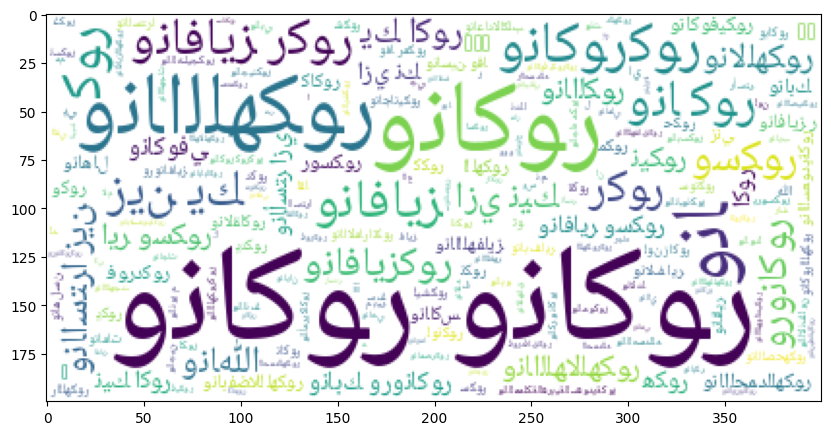

In [ ]:
!pip install -q ar_wordcloud
from ar_wordcloud import ArabicWordCloud
awc = ArabicWordCloud(background_color="white")
plt.figure(figsize = (10,10))
wc_ar = awc.from_text(u''.join(flattened_results))
plt.imshow(wc_ar)

## Negative sentence NER

In [ ]:
extracted_words_list = []

# Iterate over the NER results for each sentence
for ner_result in ner_results:
    # Extract the entities from the NER result
    entities = ner_result[0]['entities']

    # Extract the words from the entities and concatenate them
    extracted_words = ', '.join([entity['word'] for entity in entities])

    # Append the extracted words to the list
    extracted_words_list.append(extracted_words)

# Print the extracted words list
print(extracted_words_list)

['لقاح كورونا', 'الأ, الس, ##ية, ##كري, لقاح كورونا', 'لقاح كورونا', 'لقاح كورونا', 'لقاح', 'الجاي, لقاح كورونا, الشهر', 'غار, لقاح _ كورونا', 'لقاح, كورونا', 'لقاح كورونا, انفلونزا شديدة', 'لقاح, كورونا, لقاح', 'لقاح يمنع الاصابة, لقاح كورونا', 'كورونا, كورونا, بنزين', 'كورونا', '##حي, الري, الر, لقاح كورونا, ##اض بارك, مركز', 'كورونا', 'كورونا, كورونا', 'لقاح, لقاح كورونا', 'كورونا', 'الان, ##فلونزا الموسمية, FDA, كورونا', 'لقاح كورونا', 'لقاح كورونا', '##ة الغذاء والدواء الامريكية, حكام أمريكا الجدد :, هيئ, مستشفى هيوستن الأمريكية', 'كورونا', 'لقاح كورونا', '##وفار, لقاح كورونا', 'لقاح كورونا, هيمن', 'ورب العرش الع, لقاح كورونا', '', 'كورونا', '##ة الصحة, وزار, ##وبية, الأور', 'أمريكا, عسيري, رجل الشارع العادي, ،', 'كورونا', 'كورونا, لقاح', 'كورونا', 'لقاح كورونا', 'وزار, كورونا, ##ة الصحة', 'لقاح, ##ات كورونا ،', 'لقاح كورونا', 'كورونا فايروس [UNK]', 'كورونا', 'كورونا, ##ه, لقاح, الدوسري, وفا, ##ه, رفع', 'الع, ##ول, الد, كورونا', 'مرض كورونا', 'كورونا, لقاح, كورونا', 'لقاح _ كورونا

In [ ]:
negative['NER_Results']=extracted_words_list
negative.tail(5)
negative.to_csv('negative_NER.csv', index=False)

## Positive Sentence NER

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import time

# Load tokenizer and model
model_name = "abdusah/arabert-ner"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")
# Define max_len and overlap
max_len = 512
overlap = 50
def split_text(text, max_len, overlap):
    tokens = tokenizer.encode(text, add_special_tokens=False)
    token_chunks = []
    for i in range(0, len(tokens), max_len - overlap):
        token_chunks.append(tokens[i:i + max_len])
    return token_chunks

def run_chunked_pipeline(text):
    start = time.perf_counter()
    token_chunks = split_text(text, max_len, overlap)
    ner_results = []
    char_offset = 0
    reconstructed_text = ""
    for i, tokens in enumerate(token_chunks):
        chunk_text = tokenizer.decode(tokens, clean_up_tokenization_spaces=True)
        if i > 0:
            overlap_text = tokenizer.decode(tokens[:overlap], clean_up_tokenization_spaces=True)
            chunk_text = chunk_text[len(overlap_text):]
        reconstructed_text += chunk_text
        chunk_results = ner_pipeline(chunk_text)
        chunk_results = [dict(item) for item in chunk_results]
        for n in chunk_results:
            n["start"] += char_offset
            n["end"] += char_offset
        ner_results.extend(chunk_results)
        if i < len(token_chunks) - 1:
            char_offset += len(chunk_text)
        else:
            char_offset += len(chunk_text) - len(tokenizer.decode(tokens[-overlap:], clean_up_tokenization_spaces=True))
    ner_results = [dict(t) for t in {tuple(d.items()) for d in ner_results}]
    output = {"text": reconstructed_text, "entities": ner_results}
    end = time.perf_counter()
    duration = (end - start) * 1000.0
    return output, duration




In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
output, duration = run_chunked_pipeline(arabic_text)
print("Input Text:", output["text"])
print("Named Entities:")
for entity in output["entities"]:
    print(output['entities'][0]['word'])

Input Text: غير مؤيد وبشدة فرض لقاح كورونا على الاماكن العامة هو تقييد للحرية وغير مقبول تطبيقه و ينافي منهج حرية الاختيار # لا _ للتطعيم _ [UNK]
Named Entities:
لقاح كورونا


In [ ]:
run_chunked_pipeline(arabic_text)

({'text': 'غير مؤيد وبشدة فرض لقاح كورونا على الاماكن العامة هو تقييد للحرية وغير مقبول تطبيقه و ينافي منهج حرية الاختيار # لا _ للتطعيم _ [UNK]',
  'entities': [{'entity_group': 'ORG',
    'score': 0.9474019,
    'word': 'لقاح كورونا',
    'start': 19,
    'end': 30}]},
 518.719843999861)

In [ ]:
import pandas as pd

# Function to process each sentence and extract entities
def process_sentence(sentence):
    output, _ = run_chunked_pipeline(sentence)
    entities = [entity['word'] for entity in output['entities']]
    return entities

# Load your DataFrame with sentences
# Replace df['Sentence'] with your actual DataFrame column containing sentences
sentences = df['Sentence']



In [ ]:
# Process each sentence and store entities in a list
all_entities = []
for sentence in sentences:
    entities = process_sentence(sentence)
    all_entities.append(entities)


In [ ]:
len(all_entities)

2400

In [ ]:
from collections import Counter

# Flatten the list of entities
flattened_entities = [entity for sublist in all_entities for entity in sublist]

# Count the occurrences of each entity
counter1 = Counter(flattened_entities)

# Get the most common elements
most_common1 = counter1.most_common(50)

# Display the most common entities
print(most_common1)


[('كورونا', 1160), ('لقاح كورونا', 703), ('لقاح', 512), ('لقاح _ كورونا', 333), ('وزار', 143), ('##ة', 100), ('فايزر', 80), ('الم', 60), ('##ة الصحة', 44), ('السعودي', 42), ('لقاح كورونا ،', 36), ('##ة _ الصحة', 32), ('##ملك', 30), ('##كا', 29), ('لقاح فايزر', 26), ('الع', 25), ('فيروس كورونا', 25), ('لقاح _ فايزر', 24), ('الص', 23), ('الح', 22), ('حكوم', 21), ('##وس', 20), ('##اير', 20), ('الف', 19), ('FDA', 18), ('##لله', 18), ('،', 17), ('##ا', 17), ('فايروس كورونا', 17), ('##زيني', 17), ('هيئ', 16), ('منظم', 16), ('استرا', 16), ('الان', 15), ('##اح', 14), ('الك', 14), ('نظري', 14), ('الحمد', 14), ('##ات', 13), ('الد', 12), ('##ين', 12), ('##رين', 12), ('فيروس', 12), ('مصر', 12), ('لقاح # كورونا', 12), ('الس', 11), ('##ه', 11), ('##فلونزا', 11), ('لقاح _ كوفيد _ 19', 11), ('الو', 11)]


In [ ]:
most_common11 = counter1.most_common(300)
most_common12 = counter1.most_common()

In [ ]:
len(most_common12)

1446

In [ ]:
entity_df = pd.DataFrame(most_common12)
entity_df.to_excel('entity_count_all1.xlsx')
entity_df.shape

(1446, 2)

In [ ]:
entity_df[0]

0              كورونا
1         لقاح كورونا
2                لقاح
3       لقاح _ كورونا
4                وزار
            ...      
1441      ##ه الكريمه
1442             المع
1443            ##ارض
1444      لقاح إكسفور
1445          فايزر )
Name: 0, Length: 1446, dtype: object

Positive Entities:
                    entities
0                      فايزر
1                      ##ملك
2                        الف
3                      ##لله
4                     ##زيني
..                       ...
143             حمد الشاكرين
144                     عباد
145                 تحيا مصر
146                   الإمام
147  كورونا الحمدلله الأعراض

[148 rows x 1 columns]

Negative Entities:
           entities
0            كورونا
1       لقاح كورونا
2              لقاح
3     لقاح _ كورونا
4              وزار
...             ...
1293    ##ه الكريمه
1294           المع
1295          ##ارض
1296    لقاح إكسفور
1297        فايزر )

[1298 rows x 1 columns]


In [ ]:
from transformers import pipeline
import pandas as pd

# Load the sentiment analysis model
model2 = pipeline('text-classification', model='PRAli22/AraBert-Arabic-Sentiment-Analysis')

# Function to classify sentiment for entities
def classify_sentiment_for_entities(df):
    positive_entities = []
    positive_counts = []
    negative_entities = []
    negative_counts = []
    for index, row in df.iterrows():
        entity = row[0]
        count = row[1]
        # Perform sentiment analysis on the entity
        result = model2(entity)

        # Extract the label from the result
        label = result[0]['label']

        # Classify entities based on sentiment label
        if label == 'Positive':
            positive_entities.append(entity)
            positive_counts.append(count)
        else:
            negative_entities.append(entity)
            negative_counts.append(count)

    # Create DataFrames for positive and negative entities with counts
    positive_df = pd.DataFrame({'entities': positive_entities, 'count': positive_counts})
    negative_df = pd.DataFrame({'entities': negative_entities, 'count': negative_counts})

    return positive_df, negative_df



# Classify sentiment for entities in the DataFrame
positive_df, negative_df = classify_sentiment_for_entities(entity_df)

# Print the results
print("Positive Entities:")
print(positive_df)
print("\nNegative Entities:")
print(negative_df)


Positive Entities:
                    entities  count
0                      فايزر     80
1                      ##ملك     30
2                        الف     19
3                      ##لله     18
4                     ##زيني     17
..                       ...    ...
143             حمد الشاكرين      1
144                     عباد      1
145                 تحيا مصر      1
146                   الإمام      1
147  كورونا الحمدلله الأعراض      1

[148 rows x 2 columns]

Negative Entities:
           entities  count
0            كورونا   1160
1       لقاح كورونا    703
2              لقاح    512
3     لقاح _ كورونا    333
4              وزار    143
...             ...    ...
1293    ##ه الكريمه      1
1294           المع      1
1295          ##ارض      1
1296    لقاح إكسفور      1
1297        فايزر )      1

[1298 rows x 2 columns]


In [ ]:
negative_df.to_excel('negative_ner_count.xlsx')
positive_df.to_excel('positive_ner_count.xlsx')

In [ ]:
#################################################################################
#################################################################################
#################################################################################

In [ ]:
extracted_words_list1 = []

# Iterate over the NER results for each sentence
for ner_result in ner_results1:
    # Extract the entities from the NER result
    entities1 = ner_result[0]['entities']

    # Extract the words from the entities and concatenate them
    extracted_words1 = ', '.join([entity['word'] for entity in entities1])

    # Append the extracted words to the list
    extracted_words_list1.append(extracted_words1)

# Print the extracted words list
print(extracted_words_list1)

['كورونا', 'كورونا, EU, لقاح كورونا اريكسون', 'الحمد, لقاح كورونا ،, ##لله', 'لقاح كورونا', 'لقاح كورونا', 'كورونا', '##وس, ##فير, سلطن, لقاح كورونا, ##ة عمان, بال', 'كورونا, لقاح', 'لقاح استرا زينيكا فاكسين كورونا', 'لقاح فايزر', 'لقاح _ فايزر, لقاح _ كورونا, السعودي, ##ة', 'نظري, لقاح كورونا, المؤامرة, شلل الأطفال', 'صباح الورد الحمدلله, لقاح كورونا', 'لقاح كورونا, كورونا', 'لقاح كورونا', '##ات _ كورونا, لقاح كورونا, لقاح _ فايزر, لقاح _ أسترازينكا, لقاح', 'لقاح البحرين صيني', 'لقاح كوفيد _ 19, ##ويت _ كوفيد _ 19, الك, لقاح _ أكسفورد _ كورونا', 'لقاح كورونا', 'انفلونزا, كورونا, كورونا', '##ة, السعودي, لقاح _ كورونا', 'كورونا, انفلونزا الخنازير, لقاح', '##ماني, عمان, ##ة, الع', 'لقاح كورونا', '،, لقاح _ فايزر, ##جنة _ العليا, لقاح _ كورونا, فايزر, الل', 'بارو, كورونا, ##اح', 'كورونا', 'وزار, لقاح كورونا, ##ات الصحة', 'لقاح كورونا, هبل, كوني', 'لقاح # كورونا', '##كولوجي ابديت : الحلقة, لقاح كورونا, ايجي', 'لقاح كورونا, العالمين, رب', 'كورونا', 'لقاح كورونا', 'لقاح كورونا COVID - 19', '